# Trading Strategies powered by Machine Learning - Random Forest Classifier

## Random Forest Classifier with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
from backtesting import Strategy
from sklearn.ensemble import RandomForestClassifier

## Getting the Data

In [4]:
XAUUSD = load_data()

In [5]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [6]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


## ML

### Class and Strategy ML

In [7]:
class Random_Forest_Classifier(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            if self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [8]:
strategy = Random_Forest_Classifier
account_size = 2000
folder_ML_Strategy = 'Random Forest Classifier'

In [9]:
from backtesting import Backtest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_SVC():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def get_rsi(self,df, rsi_period):
        chg = df['Close'].diff(1)
        gain = chg.mask(chg < 0, 0)
        loss = chg.mask(chg > 0, 0)
        avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        rs = abs(avg_gain/avg_loss)
        rsi = 100 - (100/(1+rs))
        return rsi

    def Create_Features(self):

        df = self.data.copy()

        # relative strength index
        df['rsi14'] = self.get_rsi(df, 14)
        # moving averages
        df['sma9'] = df['Close'].rolling(9).mean()
        df['sma180'] = df['Close'].rolling(180).mean()
        df['sma9_var'] = (df['Close']/df['sma9'])-1
        df['sma180_var'] = (df['Close']/df['sma180'])-1

        self.data = df
      

    def Add_Signal(self):
        
        df = self.data.copy()
        df["returns"] = np.log(df['Close'].div(df['Close'].shift(1)))
        df['signal_t1'] = np.sign(df.returns)
        df['signal'] = df.signal_t1.shift(-1)
        df = df.drop(columns=['returns', 'signal_t1'])
        df = df.dropna()

        self.data = df


    def Train_Model(self):
        self.Create_Features()
        self.Add_Signal()

        # Extract data within the specified date range
        self.data_train = self.data.loc[self.start_train:self.end_train].copy()
        self.data_test = self.data.loc[self.start_test:self.end_test].copy()

        # Drop missing values from the training dataset
        self.data_train.dropna(inplace=True)

        y_train = self.data_train['signal'].copy()
        x_train = self.data_train.drop(columns=['signal'])
        x_test = self.data_test.drop(columns=['signal'])

        self.model = RandomForestClassifier()
        self.model.fit(x_train, y_train)

        # Make predictions
        self.data_train['pred'] = self.model.predict(x_train)
        self.data_test['pred'] = self.model.predict(x_test)
      

    def Backtest(self, data, account_size=2000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1 / 2000)
        result = backtest.run()
        return result

    def Run(self):

        self.Train_Model()

        result_train = self.Backtest(self.data_train)

        result_test = self.Backtest(self.data_test)

        return result_train, result_test

In [10]:
ML_Class = ML_SVC

## TF D1

In [11]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'D1'

In [12]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [13]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_5112\1314468544.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_5112\1314468544.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [14]:
train

Start                     2007-07-29 00:00:00
End                       2020-12-31 00:00:00
Duration                   4904 days 00:00:00
Exposure Time [%]                    99.95221
Equity Final [$]                    37353.893
Equity Peak [$]                     37353.893
Return [%]                         1767.69465
Buy & Hold Return [%]              187.262464
Return (Ann.) [%]                   19.275639
Volatility (Ann.) [%]                2.299886
Sharpe Ratio                         8.381128
Sortino Ratio                      230.702855
Calmar Ratio                        93.110966
Max. Drawdown [%]                   -0.207018
Avg. Drawdown [%]                    -0.01581
Max. Drawdown Duration        5 days 00:00:00
Avg. Drawdown Duration        4 days 00:00:00
# Trades                                 2152
Win Rate [%]                        97.769517
Best Trade [%]                      15.845498
Worst Trade [%]                     -1.216887
Avg. Trade [%]                    

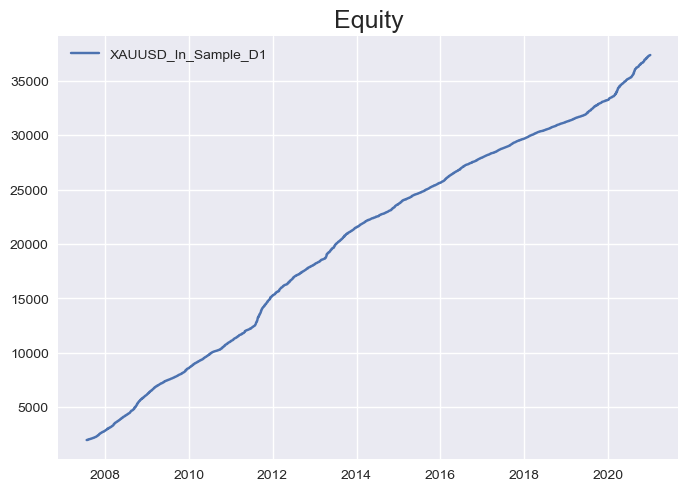

In [15]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [16]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   1163 days 00:00:00
Exposure Time [%]                    99.79798
Equity Final [$]                     6556.291
Equity Peak [$]                      6650.952
Return [%]                          227.81455
Buy & Hold Return [%]               20.623928
Return (Ann.) [%]                   35.285366
Volatility (Ann.) [%]                7.872856
Sharpe Ratio                         4.481902
Sortino Ratio                       15.260772
Calmar Ratio                           6.7409
Max. Drawdown [%]                   -5.234519
Avg. Drawdown [%]                   -0.683663
Max. Drawdown Duration      312 days 00:00:00
Avg. Drawdown Duration       27 days 00:00:00
# Trades                                  413
Win Rate [%]                        69.733656
Best Trade [%]                       9.300688
Worst Trade [%]                     -5.678162
Avg. Trade [%]                    

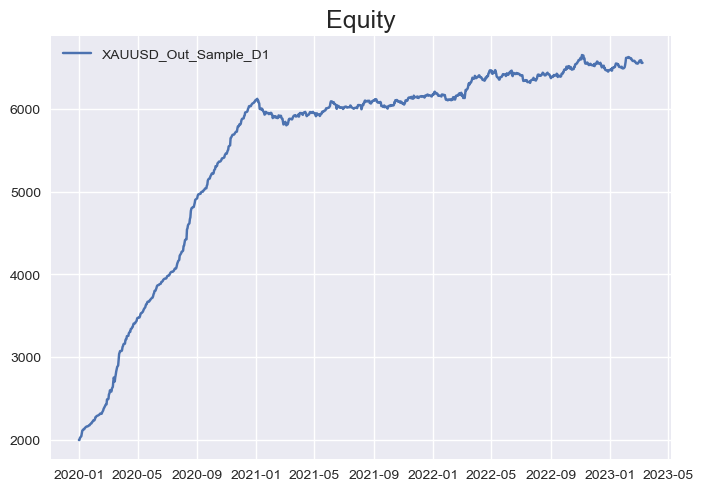

In [17]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [18]:
filename_train = f'result_{TF}_In_Sample.csv'

In [19]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [20]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [21]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [22]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H4'

In [23]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [24]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_5112\1314468544.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_5112\1314468544.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [25]:
train

Start                     2007-02-09 00:00:00
End                       2020-12-31 20:00:00
Duration                   5074 days 20:00:00
Exposure Time [%]                    99.99103
Equity Final [$]                    77727.752
Equity Peak [$]                     77727.752
Return [%]                          3786.3876
Buy & Hold Return [%]               188.08708
Return (Ann.) [%]                   23.706907
Volatility (Ann.) [%]                2.509202
Sharpe Ratio                         9.447985
Sortino Ratio                      571.795699
Calmar Ratio                       198.497574
Max. Drawdown [%]                   -0.119432
Avg. Drawdown [%]                    -0.00613
Max. Drawdown Duration        4 days 04:00:00
Avg. Drawdown Duration        1 days 07:00:00
# Trades                                11502
Win Rate [%]                        98.287254
Best Trade [%]                      11.391034
Worst Trade [%]                     -0.761831
Avg. Trade [%]                    

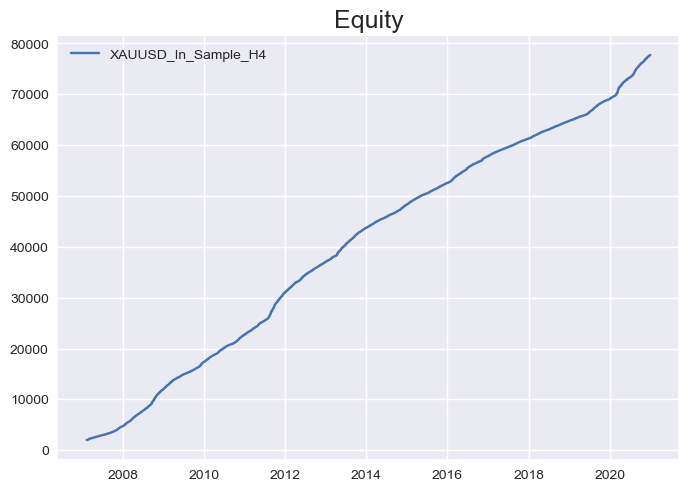

In [26]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [27]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 12:00:00
Duration                   1163 days 16:00:00
Exposure Time [%]                   99.960815
Equity Final [$]                    10920.982
Equity Peak [$]                     10973.585
Return [%]                           446.0491
Buy & Hold Return [%]               22.702589
Return (Ann.) [%]                   53.981879
Volatility (Ann.) [%]               10.241332
Sharpe Ratio                         5.270982
Sortino Ratio                       42.191327
Calmar Ratio                        16.268925
Max. Drawdown [%]                   -3.318098
Avg. Drawdown [%]                   -0.190884
Max. Drawdown Duration      472 days 12:00:00
Avg. Drawdown Duration       13 days 06:00:00
# Trades                                 1995
Win Rate [%]                        71.829574
Best Trade [%]                       7.052948
Worst Trade [%]                     -5.094316
Avg. Trade [%]                    

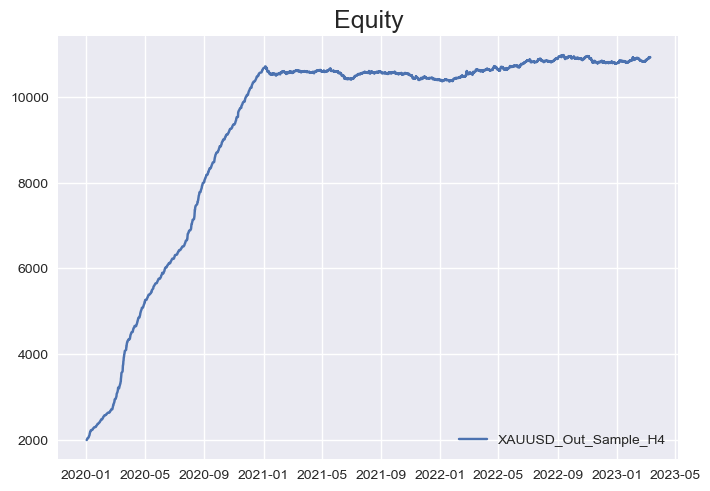

In [28]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [29]:
filename_train = f'result_{TF}_In_Sample.csv'

In [30]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [31]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [32]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [33]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H1'

In [34]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [35]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_5112\1314468544.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_5112\1314468544.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [36]:
train

Start                     2007-01-10 11:00:00
End                       2020-12-31 21:00:00
Duration                   5104 days 10:00:00
Exposure Time [%]                   99.997643
Equity Final [$]                   146849.852
Equity Peak [$]                    146852.625
Return [%]                          7242.4926
Buy & Hold Return [%]              210.556125
Return (Ann.) [%]                   28.154677
Volatility (Ann.) [%]                3.261143
Sharpe Ratio                         8.633376
Sortino Ratio                     1297.915181
Calmar Ratio                       349.053168
Max. Drawdown [%]                    -0.08066
Avg. Drawdown [%]                   -0.003504
Max. Drawdown Duration        3 days 14:00:00
Avg. Drawdown Duration        0 days 09:00:00
# Trades                                44631
Win Rate [%]                        97.539827
Best Trade [%]                      10.936788
Worst Trade [%]                     -0.930384
Avg. Trade [%]                    

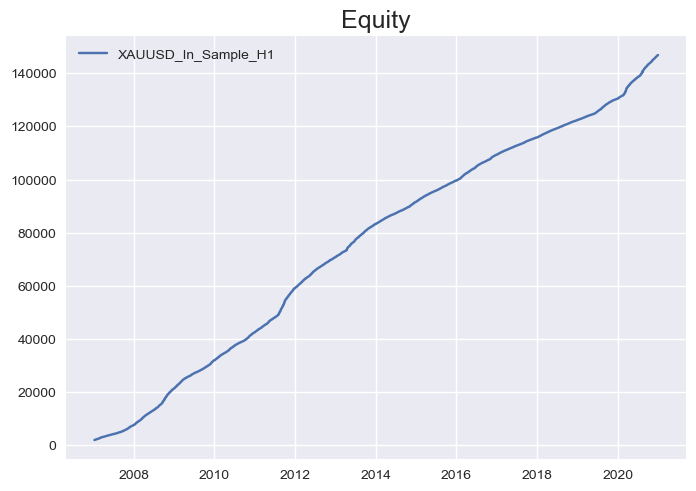

In [37]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [38]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 17:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                      19448.5
Equity Peak [$]                     19548.537
Return [%]                            872.425
Buy & Hold Return [%]               22.191486
Return (Ann.) [%]                   78.320201
Volatility (Ann.) [%]               15.542833
Sharpe Ratio                         5.038991
Sortino Ratio                      115.003334
Calmar Ratio                        90.733112
Max. Drawdown [%]                   -0.863193
Avg. Drawdown [%]                    -0.05618
Max. Drawdown Duration      121 days 05:00:00
Avg. Drawdown Duration        3 days 00:00:00
# Trades                                 7550
Win Rate [%]                        72.980132
Best Trade [%]                        5.43235
Worst Trade [%]                     -2.266967
Avg. Trade [%]                    

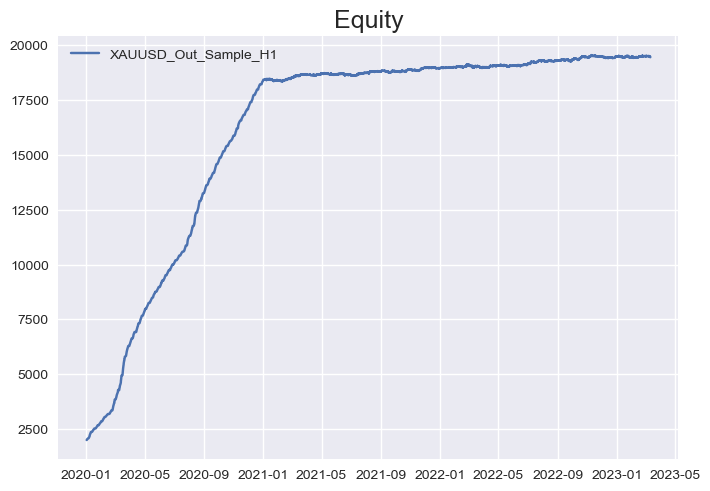

In [39]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [40]:
filename_train = f'result_{TF}_In_Sample.csv'

In [41]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [42]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [43]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [44]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M30'

In [45]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

Start                     2007-01-04 17:30:00
End                       2020-12-31 21:30:00
Duration                   5110 days 04:00:00
Exposure Time [%]                   99.998818
Equity Final [$]                    206016.77
Equity Peak [$]                    206017.153
Return [%]                         10200.8385
Buy & Hold Return [%]              203.406471
Return (Ann.) [%]                   30.693152
Volatility (Ann.) [%]                3.860654
Sharpe Ratio                         7.950246
Sortino Ratio                     4607.752292
Calmar Ratio                       272.516439
Max. Drawdown [%]                   -0.112629
Avg. Drawdown [%]                   -0.003244
Max. Drawdown Duration        3 days 09:30:00
Avg. Drawdown Duration        0 days 04:37:00
# Trades                                88865
Win Rate [%]                        97.416306
Best Trade [%]                       8.111091
Worst Trade [%]                     -0.961891
Avg. Trade [%]                    

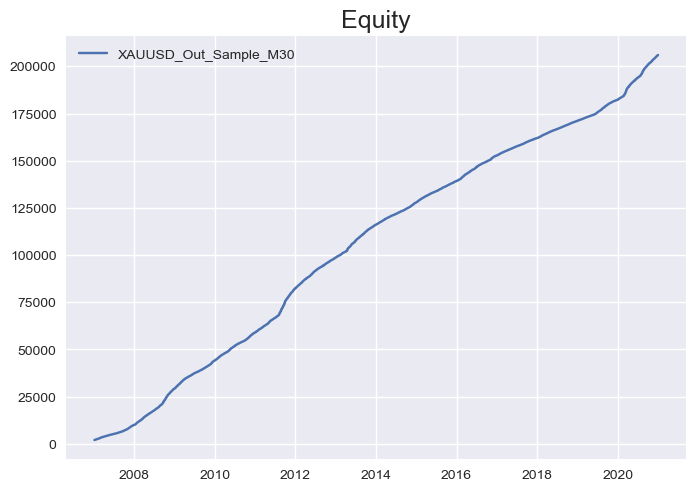

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.994697
Equity Final [$]                    26555.609
Equity Peak [$]                     26606.738
Return [%]                         1227.78045
Buy & Hold Return [%]               22.568469
Return (Ann.) [%]                   93.018174
Volatility (Ann.) [%]               19.716454
Sharpe Ratio                         4.717794
Sortino Ratio                      195.933995
Calmar Ratio                       107.257553
Max. Drawdown [%]                   -0.867241
Avg. Drawdown [%]                   -0.036336
Max. Drawdown Duration      128 days 10:30:00
Avg. Drawdown Duration        2 days 11:25:00
# Trades                                15442
Win Rate [%]                        72.769071
Best Trade [%]                        4.93245
Worst Trade [%]                     -4.101955
Avg. Trade [%]                    

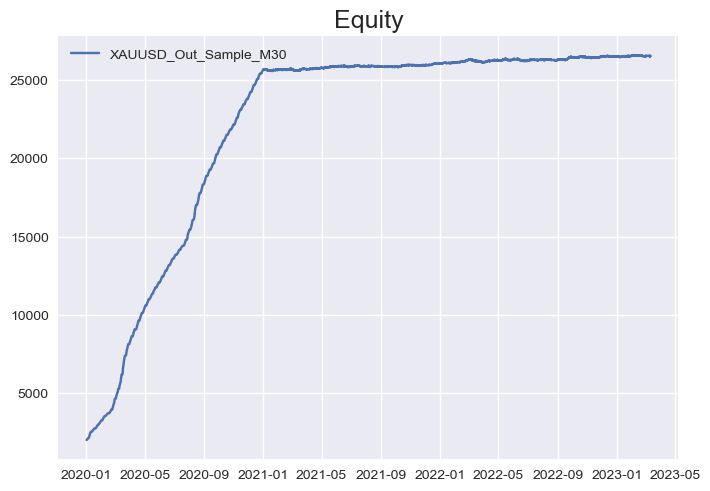

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [ ]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M15'

In [ ]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_21320\1314468544.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_21320\1314468544.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [ ]:
train

Start                     2014-09-25 11:15:00
End                       2020-12-31 21:45:00
Duration                   2289 days 10:30:00
Exposure Time [%]                    99.99865
Equity Final [$]                    117546.25
Equity Peak [$]                      117546.7
Return [%]                          5777.3125
Buy & Hold Return [%]               56.814811
Return (Ann.) [%]                   68.792465
Volatility (Ann.) [%]               10.028959
Sharpe Ratio                         6.859382
Sortino Ratio                     2928.024602
Calmar Ratio                       203.638646
Max. Drawdown [%]                   -0.337816
Avg. Drawdown [%]                   -0.001335
Max. Drawdown Duration        3 days 06:15:00
Avg. Drawdown Duration        0 days 03:56:00
# Trades                                77118
Win Rate [%]                         98.71366
Best Trade [%]                       4.112577
Worst Trade [%]                     -1.254982
Avg. Trade [%]                    

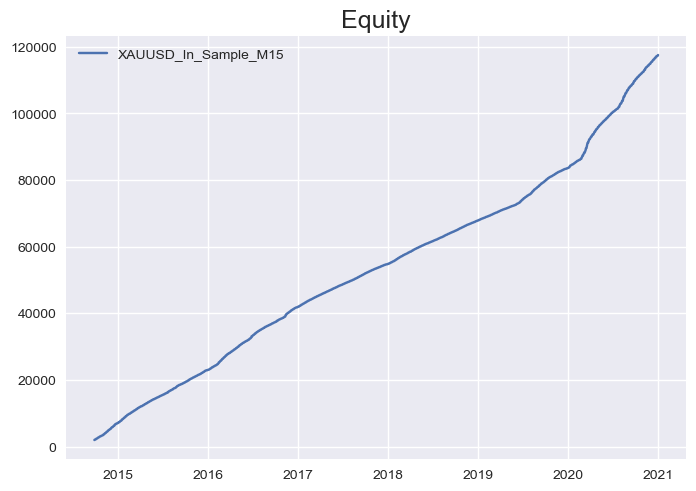

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:30:00
Exposure Time [%]                   99.997348
Equity Final [$]                    36861.336
Equity Peak [$]                     36910.015
Return [%]                          1743.0668
Buy & Hold Return [%]               22.665911
Return (Ann.) [%]                  109.768725
Volatility (Ann.) [%]               25.088267
Sharpe Ratio                         4.375301
Sortino Ratio                      293.540736
Calmar Ratio                       150.333128
Max. Drawdown [%]                    -0.73017
Avg. Drawdown [%]                   -0.018545
Max. Drawdown Duration      237 days 00:00:00
Avg. Drawdown Duration        1 days 08:45:00
# Trades                                30393
Win Rate [%]                         72.97075
Best Trade [%]                       4.112577
Worst Trade [%]                     -3.308873
Avg. Trade [%]                    

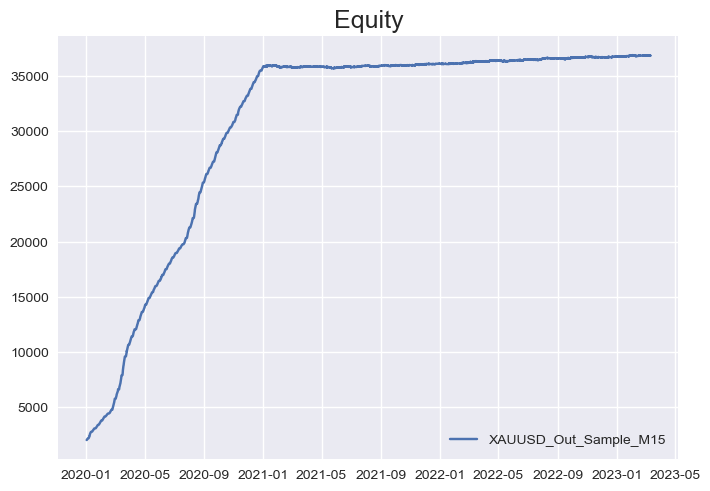

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [ ]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M5'

In [ ]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_21320\1314468544.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


### In-Sample Backtesting

In [ ]:
train

Start                     2020-05-18 03:05:00
End                       2023-03-10 17:50:00
Duration                   1026 days 14:45:00
Exposure Time [%]                   99.998999
Equity Final [$]                   139490.329
Equity Peak [$]                    139490.933
Return [%]                         6874.51645
Buy & Hold Return [%]                5.886468
Return (Ann.) [%]                   230.43979
Volatility (Ann.) [%]               47.941496
Sharpe Ratio                         4.806688
Sortino Ratio                     3624.385974
Calmar Ratio                       705.299333
Max. Drawdown [%]                   -0.326726
Avg. Drawdown [%]                   -0.000673
Max. Drawdown Duration        3 days 04:30:00
Avg. Drawdown Duration        0 days 01:15:00
# Trades                               102538
Win Rate [%]                        98.788742
Best Trade [%]                       2.888443
Worst Trade [%]                     -0.876337
Avg. Trade [%]                    

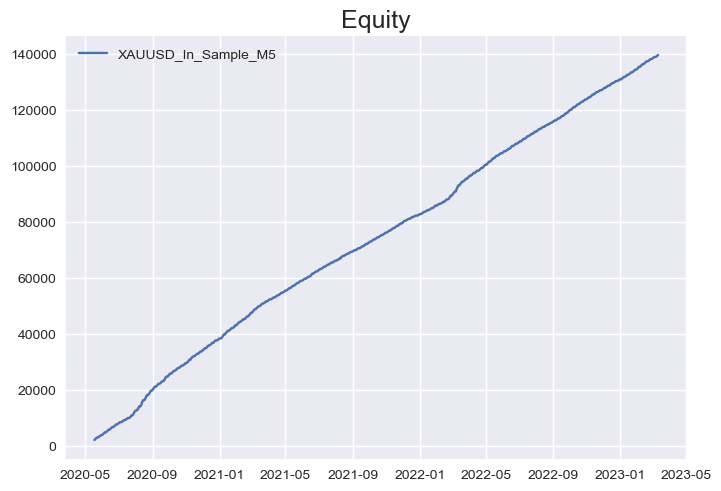

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:50:00
Duration                     66 days 18:50:00
Exposure Time [%]                   99.985069
Equity Final [$]                    10696.555
Equity Peak [$]                     10697.159
Return [%]                          434.82775
Buy & Hold Return [%]                 2.07534
Return (Ann.) [%]               125920.132419
Volatility (Ann.) [%]            45804.457307
Sharpe Ratio                          2.74908
Sortino Ratio                             inf
Calmar Ratio                   1115002.832255
Max. Drawdown [%]                   -0.112933
Avg. Drawdown [%]                   -0.002583
Max. Drawdown Duration        2 days 01:25:00
Avg. Drawdown Duration        0 days 01:36:00
# Trades                                 6860
Win Rate [%]                        98.979592
Best Trade [%]                       1.610684
Worst Trade [%]                     -0.119591
Avg. Trade [%]                    

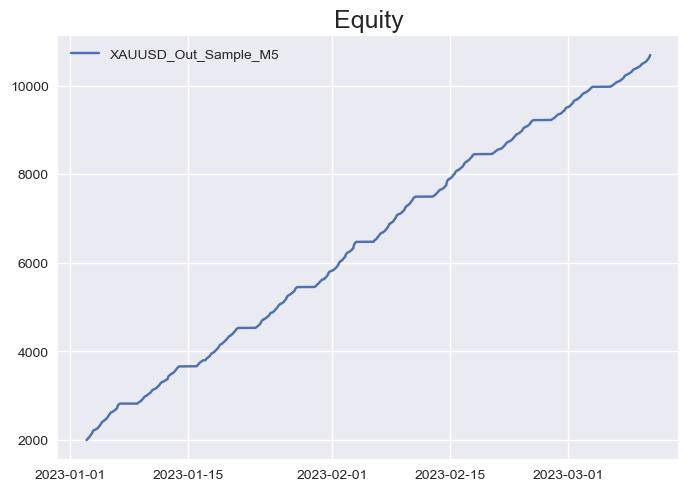

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [ ]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M1'

In [ ]:
ml = ML_Class(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


### In-Sample Backtesting

In [ ]:
train

Start                     2022-08-17 02:12:00
End                       2023-03-10 17:58:00
Duration                    205 days 15:46:00
Exposure Time [%]                   99.998999
Equity Final [$]                    58107.957
Equity Peak [$]                      58108.28
Return [%]                         2805.39785
Buy & Hold Return [%]                4.961604
Return (Ann.) [%]                10253.483443
Volatility (Ann.) [%]             3785.370691
Sharpe Ratio                         2.708713
Sortino Ratio                             inf
Calmar Ratio                    302469.225092
Max. Drawdown [%]                   -0.033899
Avg. Drawdown [%]                   -0.000394
Max. Drawdown Duration        3 days 01:08:00
Avg. Drawdown Duration        0 days 00:11:00
# Trades                                99014
Win Rate [%]                        97.037793
Best Trade [%]                        1.29732
Worst Trade [%]                     -0.378417
Avg. Trade [%]                    

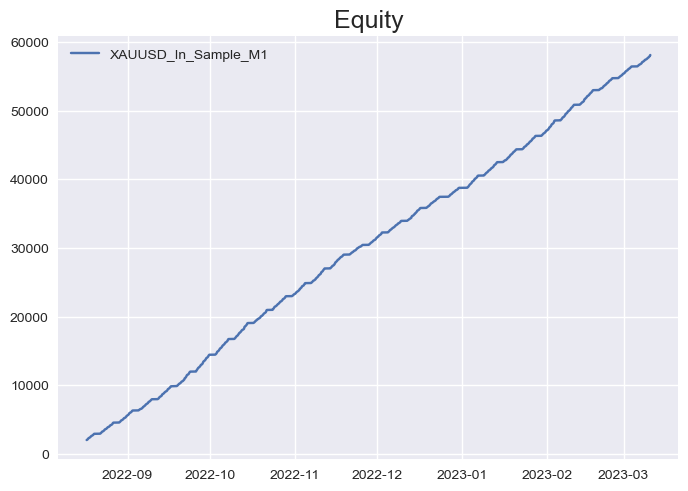

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:58:00
Duration                     66 days 18:58:00
Exposure Time [%]                   99.997013
Equity Final [$]                    21356.648
Equity Peak [$]                     21356.971
Return [%]                           967.8324
Buy & Hold Return [%]                2.050654
Return (Ann.) [%]              2358726.218933
Volatility (Ann.) [%]          1769583.014238
Sharpe Ratio                         1.332928
Sortino Ratio                             inf
Calmar Ratio                  46295666.415032
Max. Drawdown [%]                   -0.050949
Avg. Drawdown [%]                   -0.000608
Max. Drawdown Duration        2 days 01:09:00
Avg. Drawdown Duration        0 days 00:06:00
# Trades                                33240
Win Rate [%]                        97.698556
Best Trade [%]                       0.958268
Worst Trade [%]                     -0.119591
Avg. Trade [%]                    

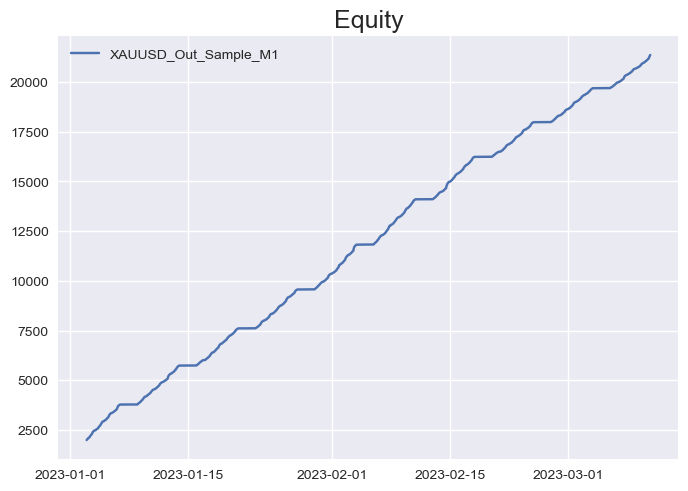

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')